In [1]:
from helper import *
import spacy;
nlp = spacy.load("en_core_sci_md")

japflow_data = json.load(open('../data/japflow/all.json'))
risec_data   = json.load(open('../data/risec/train.json'))

## Vocabulary Overlap Mismatch

In [2]:
risec_vocab, japflow_vocab, risec_ent_vocab, japflow_ent_vocab  = ddict(int), ddict(int), ddict(int), ddict(int) 

for elem in japflow_data:
    words = [x.text.lower() for x in nlp(elem['text'])]
    for word in words:
        japflow_vocab[word]         +=1

for elem in risec_data:
    words = [x.text.lower() for x in nlp(elem['text'])]
    for word in words:
        risec_vocab[word]           +=1    

for elem in japflow_data:
    anns = elem['anns']
    for ann in anns:
        japflow_ent_vocab[ann['word'].lower()]+=1

for elem in risec_data:
    anns = elem['anns']
    for ann in anns:
        risec_ent_vocab[ann['word'].lower()]+=1

risec_vocab_set     = set(risec_vocab.keys())
japflow_vocab_set   = set(japflow_vocab.keys())
risec_ent_set       = set(risec_ent_vocab.keys())
japflow_ent_set     = set(japflow_ent_vocab.keys())

oov_japflow         = len(japflow_vocab_set - risec_vocab_set)/len(japflow_vocab_set)
oov_japflow_ent     = len(japflow_ent_set - risec_ent_set)/len(japflow_ent_set)

print(oov_japflow, oov_japflow_ent)

0.5647977941176471 0.822380106571936


## Sentence Length Distribution

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

risec_sent_dict, japflow_sent_dict = ddict(int), ddict(int)
tot_risec_sents, tot_japflow_sents = 0,0
for elem in risec_data:
    sents = [x for x in nlp(elem['text']).sents]
    for sent in sents:
        risec_sent_dict[min(len(sent),40)] +=1
        tot_risec_sents            +=1

for elem in japflow_data:
    sents = [x for x in nlp(elem['text']).sents]
    for sent in sents:
        japflow_sent_dict[min(len(sent),40)] +=1
        tot_japflow_sents            +=1

sent_dict = ddict(list)
for elem in risec_sent_dict:
    sent_dict['length'].append(elem)
    sent_dict['prop'].append(risec_sent_dict[elem]/tot_risec_sents)
    sent_dict['data'].append('risec')

for elem in japflow_sent_dict:
    sent_dict['length'].append(elem)
    sent_dict['prop'].append(japflow_sent_dict[elem]/tot_japflow_sents)
    sent_dict['data'].append('japflow')

sent_df = pd.DataFrame(sent_dict)


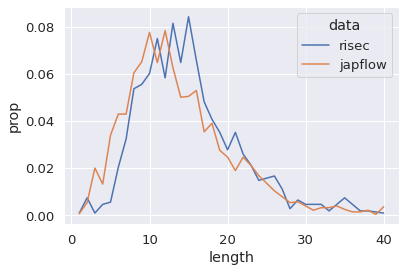

In [4]:
sns.lineplot(data= sent_df, x='length',y='prop', hue='data')
plt.show()

## Distribution of the dependency links between entities

In [24]:
risec_rels 							= 	load_dill(f'../data/risec/data.dill')['train']['rels']
japflow_rels 						= 	load_dill(f'../data/japflow/data.dill')['all']['rels']

In [13]:
import networkx as nx
risec_min_path_dict                 = ddict(int)

for rel in tqdm(risec_rels):
    org_toks, toks_range            = rel['org_toks'], rel['tok_range']
    sent                            = org_toks[0]
    for i in range(1, len(org_toks)):
        diff                        = toks_range[i][0] - toks_range[i-1][1]
        for j in range(diff): sent+= ' '
        sent                        +=org_toks[i]
    obj1_start, obj1_end, obj1_text = rel['span_info'][0], rel['span_info'][1],rel['span_info'][2]
    obj2_start, obj2_end, obj2_text = rel['span_info'][4], rel['span_info'][5],rel['span_info'][6]
    
    doc                         = nlp(sent)
    src_ents, tgt_ents, edges   = [],[],[]
    
    for token in doc:
        if token.pos_ in ['DET','CONJ','SYM']: continue
        if token.text in obj1_text: src_ents.append(token.text)
        if token.text in obj2_text: tgt_ents.append(token.text)
        for child in token.children:
            edges.append(('{0}'.format(token.text),'{0}'.format(child.text)))
    
    graph = nx.Graph(edges)
    min_path= len(org_toks)
    
    for src in src_ents:
        for tgt in tgt_ents:
            try:
                min_path = min(min_path, nx.shortest_path_length(graph, source=src, target=tgt))    
            except Exception as e:
                continue
    
    risec_min_path_dict[min_path]+=1


100%|██████████| 3689/3689 [00:35<00:00, 103.02it/s]


In [15]:
japflow_min_path_dict                 = ddict(int)

for rel in tqdm(japflow_rels):
    org_toks, toks_range            = rel['org_toks'], rel['tok_range']
    sent                            = org_toks[0]
    for i in range(1, len(org_toks)):
        diff                        = toks_range[i][0] - toks_range[i-1][1]
        for j in range(diff): sent+= ' '
        sent                        +=org_toks[i]
    obj1_start, obj1_end, obj1_text = rel['span_info'][0], rel['span_info'][1],rel['span_info'][2]
    obj2_start, obj2_end, obj2_text = rel['span_info'][4], rel['span_info'][5],rel['span_info'][6]
    
    doc                         = nlp(sent)
    src_ents, tgt_ents, edges   = [],[],[]
    
    for token in doc:
        if token.pos_ in ['DET','CONJ','SYM']: continue
        if token.text in obj1_text: src_ents.append(token.text)
        if token.text in obj2_text: tgt_ents.append(token.text)
        for child in token.children:
            edges.append(('{0}'.format(token.text),'{0}'.format(child.text)))
    
    graph = nx.Graph(edges)
    min_path= len(org_toks)
    
    for src in src_ents:
        for tgt in tgt_ents:
            try:
                min_path = min(min_path, nx.shortest_path_length(graph, source=src, target=tgt))    
            except Exception as e:
                continue
    japflow_min_path_dict[min_path]+=1


100%|██████████| 15861/15861 [02:51<00:00, 92.28it/s] 


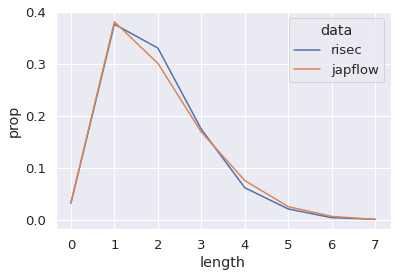

In [25]:
risec_deps      = np.sum([risec_min_path_dict[elem] for elem in risec_min_path_dict])
japflow_deps    = np.sum([japflow_min_path_dict[elem] for elem in japflow_min_path_dict])

dep_dict        = ddict(list)

for path in risec_min_path_dict:
    dep_dict['length'].append(min(path,7))
    dep_dict['prop'].append(risec_min_path_dict[path]/risec_deps)
    dep_dict['data'].append('risec')

for path in japflow_min_path_dict:
    dep_dict['length'].append(min(path,7))
    dep_dict['prop'].append(japflow_min_path_dict[path]/japflow_deps)
    dep_dict['data'].append('japflow')

dep_df          = pd.DataFrame(dep_dict)

sns.lineplot(data= dep_df, x='length',y='prop', hue='data')

plt.show()    

In [29]:

for rel in tqdm(risec_rels):
    if rel['span_info'][-1] != 'Arg_PAG': continue
    org_toks, toks_range            = rel['org_toks'], rel['tok_range']
    sent                            = org_toks[0]
    for i in range(1, len(org_toks)):
        diff                        = toks_range[i][0] - toks_range[i-1][1]
        for j in range(diff): sent+= ' '
        sent                        +=org_toks[i]
    obj1_start, obj1_end, obj1_text = rel['span_info'][0], rel['span_info'][1],rel['span_info'][2]
    obj2_start, obj2_end, obj2_text = rel['span_info'][4], rel['span_info'][5],rel['span_info'][6]    
    print(sent, rel['span_info'])

print('\n\n****************************\n\n')
for rel in tqdm(japflow_rels):
    if rel['span_info'][-1] != 'agent': continue
    org_toks, toks_range            = rel['org_toks'], rel['tok_range']
    sent                            = org_toks[0]
    for i in range(1, len(org_toks)):
        diff                        = toks_range[i][0] - toks_range[i-1][1]
        for j in range(diff): sent+= ' '
        sent                        +=org_toks[i]
    obj1_start, obj1_end, obj1_text = rel['span_info'][0], rel['span_info'][1],rel['span_info'][2]
    obj2_start, obj2_end, obj2_text = rel['span_info'][4], rel['span_info'][5],rel['span_info'][6]    
    if sent.startswith('Let'):
        print(sent, rel['span_info'])
    

100%|██████████| 15861/15861 [00:00<00:00, 364785.08it/s]

12) When inserted it should come out clean. (589, 593, 'come', 'AC', 579, 581, 'it', 'TOOL', 'Arg_PAG')
4) Let them warm up for about 90 seconds. (183, 190, 'warm up', 'AC', 178, 182, 'them', 'FOOD', 'Arg_PAG')
8) Let them cool for 2 minutes before removing from cookie sheets to cool completely. (451, 455, 'cool', 'AC', 446, 450, 'them', 'FOOD', 'Arg_PAG')
9) Beat on low speed for 2 minutes. 10) Let stand for 2-3 minutes. (452, 457, 'stand', 'AC', 411, 415, 'Beat', 'AC', 'Arg_PAG')
3) Remove from the heat and let stand at room temperature until cold, several hours. (158, 163, 'stand', 'AC', 129, 135, 'Remove', 'AC', 'Arg_PAG')
7) Overbeaten egg whites lose volume and deflate when folded into other ingredients. (350, 354, 'lose', 'AC', 328, 349, 'Overbeaten egg whites', 'FOOD', 'Arg_PAG')
7) Overbeaten egg whites lose volume and deflate when folded into other ingredients. (366, 373, 'deflate', 'AC', 328, 349, 'Overbeaten egg whites', 'FOOD', 'Arg_PAG')
8) Be absolutely sure not a partic

In [ ]:
for rel in tqdm(risec_rels):
    if rel['span_info'][-1] != 'Arg_': continue
    org_toks, toks_range            = rel['org_toks'], rel['tok_range']
    sent                            = org_toks[0]
    for i in range(1, len(org_toks)):
        diff                        = toks_range[i][0] - toks_range[i-1][1]
        for j in range(diff): sent+= ' '
        sent                        +=org_toks[i]
    obj1_start, obj1_end, obj1_text = rel['span_info'][0], rel['span_info'][1],rel['span_info'][2]
    obj2_start, obj2_end, obj2_text = rel['span_info'][4], rel['span_info'][5],rel['span_info'][6]    
    print(sent, rel['span_info'])

print('\n\n****************************\n\n')
for rel in tqdm(japflow_rels):
    if rel['span_info'][-1] != 'dest': continue
    org_toks, toks_range            = rel['org_toks'], rel['tok_range']
    sent                            = org_toks[0]
    for i in range(1, len(org_toks)):
        diff                        = toks_range[i][0] - toks_range[i-1][1]
        for j in range(diff): sent+= ' '
        sent                        +=org_toks[i]
    obj1_start, obj1_end, obj1_text = rel['span_info'][0], rel['span_info'][1],rel['span_info'][2]
    obj2_start, obj2_end, obj2_text = rel['span_info'][4], rel['span_info'][5],rel['span_info'][6]    
    if sent.startswith('Let'):
        print(sent, rel['span_info'])
    